## Connect with Google Drive 

In [0]:
from google.colab import drive 
drive.mount("/betogaona7")

In [0]:
%cd ./../betogaona7/My\ Drive/app/Recognition

In [0]:
%pwd

## Imports 

In [0]:
import tensorflow as tf 
import matplotlib.pyplot as plt
import os

from PIL import Image
import numpy as np
from sklearn.model_selection import train_test_split

## Download and prepare data

The dataset consists of 25 subjects (19 male and 6 female), frame rate of 30 fps, and image resolution of 800 x 600px.  Faces has the size of 96 x 96px.

In [0]:
!pip install object_detection 

In [0]:
!wget https://zenodo.org/record/815657/files/P1E.tar.xz
!wget https://zenodo.org/record/815657/files/P1L.tar.xz
!wget https://zenodo.org/record/815657/files/P2E.tar.xz
!wget https://zenodo.org/record/815657/files/P2L.tar.xz

In [0]:
!tar -xvf P1E.tar.xz
!tar -xvf P1L.tar.xz
!tar -xvf P2E.tar.xz
!tar -xvf P2L.tar.xz

In [0]:
!rm P1E.tar.xz
!rm P1L.tar.xz
!rm P2E.tar.xz
!rm P2L.tar.xz

In [0]:
%ls P1E_S1_C1/0001

00002439.pgm  00002451.pgm  00002463.pgm  00002477.pgm  00002489.pgm
00002440.pgm  00002452.pgm  00002464.pgm  00002478.pgm  00002490.pgm
00002441.pgm  00002453.pgm  00002465.pgm  00002479.pgm  00002491.pgm
00002442.pgm  00002454.pgm  00002466.pgm  00002480.pgm  00002492.pgm
00002443.pgm  00002455.pgm  00002467.pgm  00002481.pgm  00002493.pgm
00002444.pgm  00002456.pgm  00002468.pgm  00002482.pgm  00002494.pgm
00002445.pgm  00002457.pgm  00002469.pgm  00002483.pgm  00002495.pgm
00002446.pgm  00002458.pgm  00002470.pgm  00002484.pgm  00002496.pgm
00002447.pgm  00002459.pgm  00002471.pgm  00002485.pgm  00002497.pgm
00002448.pgm  00002460.pgm  00002472.pgm  00002486.pgm  00002498.pgm
00002449.pgm  00002461.pgm  00002473.pgm  00002487.pgm  00002499.pgm
00002450.pgm  00002462.pgm  00002474.pgm  00002488.pgm  00002500.pgm


(96, 96)


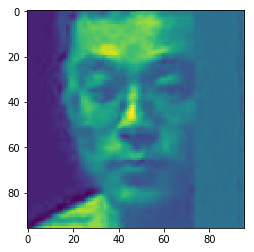

In [0]:
img = np.array(Image.open("./P1E_S1_C1/0001/00002439.pgm"))
print(img.shape)
plt.imshow(img)

In [0]:
def imgs_with_id(src):
  data = []
  imgs = 0
  for path, subdir, files in os.walk(src):
    for file in files:
      #if path[9:12] == "P1E":
       if file[-3:] == 'pgm':
        data.append((os.path.join(path, file), path[-2:]))
        imgs += 1
  return data, imgs

# Working first with a small toy datastet
data, total = imgs_with_id("./data")

In [0]:
img_path, img_id = data[23]

print("img: ", img_path, " subject id: ", img_id, " Total imgs: ", total)

img:  ./data/s05/7.pgm  subject id:  05  Total imgs:  400


## Create TFRecord 

In [0]:
import cv2
def _bytes_feature(value):
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _int64_feature(value):
  return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

tfr_name = "data.tfrecord"
writer = tf.python_io.TFRecordWriter(tfr_name)

# Just to double check
original_imgs = []

for img_path, subject_id in data:
  
  img = read_image(img_path, 'rw+')#Image.open(img_path)
  height = 112
  width = 92
  img_data = img.tobytes()
  path = str.encode(img_path)
  
  example = tf.train.Example(features=tf.train.Features(feature={
      'label': _int64_feature(label),
      'image': tf.train.Feature(bytes_list=tf.train.BytesList(value=[img_data])),
      'height': _int64_feature(height),
      'width': _int64_feature(width),
      'addr': _bytes_feature(path)}))
  
  writer.write(example.SerializeToString())

writer.close()

In [117]:
for example in tf.python_io.tf_record_iterator("data.tfrecord"):
  result = tf.train.Example.FromString(example)
print(result)

features {
  feature {
    key: "addr"
    value {
      bytes_list {
        value: "./data/s01/2.pgm"
      }
    }
  }
  feature {
    key: "height"
    value {
      int64_list {
        value: 112
      }
    }
  }
  feature {
    key: "image"
    value {
      bytes_list {
        value: "<<>503=<GDNHGJNXXMS\\_drzw~\210\212\217\217\223\221\221\217\227\224\226\225\226\227\227\234\235\234\214\225\233\224\215\207\217\216\221\231\231\234\234\232\241\233\234\236\227\224\222\212\211\211\202}toihgfN@@N[<2=VKJ7$(5.:I6?>E==EEGUY[TVPLQan\200\207\203\177\207\214\220\220\216\216\217\221\217\222\223\222\224\220\226\227\230\227\225\225\223\227\225\222\217\224\226\227\226\232\232\225\227\242\237\255\246\252\236\232\220\211\210\210\205zqphon^HIKXN-<FM0A(\"23DMPC9BBAMQX_X`\\fU_kx\200\205\216\203\204\220\217\215\215\221\217\220\223\223\225\222\224\226\221\230\230\233\226\227\224\227\225\233\224\225\227\233\231\236\234\235\225\223\253\247\273\273\273\246\247\246\231\224\213\212\202}sppokYS@[O25JQ02

## Build dataset 

In [0]:
def make_single_dataset(image_size, tfrecords_path="./data.tfrecord", shuffle_buffer_size=2000, repeat=True, train=True):
  image_size = tf.cast(image_size, tf.int32)
  
  def _parse_function(example_proto):
    features = {'label': tf.FixedLenFeature((), tf.int64, default_value=1),
                'image': tf.FixedLenFeature((), tf.string, default_value=""),
                'height': tf.FixedLenFeature([], tf.int64),
                'width': tf.FixedLenFeature([], tf.int64),
                'addr': tf.FixedLenFeature((), tf.string, default_value="")}
    
    parsed_features = tf.parse_single_example(example_proto, features)
  
    image = tf.decode_raw(parsed_features['image'], tf.uint8)
    img_shape = tf.stack([tf.cast(parsed_features['height'], tf.int32),
                         tf.cast(parsed_features['width'], tf.int32), 1])
    
    image = tf.reshape(image, img_shape)
    
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize_images(image, [image_size, image_size])
    
    return image, parsed_features['label'], parsed_features['addr']
    
  dataset = tf.data.TFRecordDataset(tfrecords_path)
  dataset = dataset.shuffle(shuffle_buffer_size)
  dataset = dataset.map(_parse_function)
  
  return dataset  


def combine_dataset(batch_size, image_size, same_prob, diff_prob, repeat=True, train=True):
	dataset_left = make_single_dataset(image_size, repeat=repeat, train=train)
	dataset_right = make_single_dataset(image_size, repeat=repeat, train=train)

	dataset = tf.data.Dataset.zip((dataset_left, dataset_right))

	if train:
		filter_func = create_filter_func(same_prob, diff_prob)
		dataset = dataset.filter(filter_func)
	if repeat:
		dataset = dataset.repeat()

	dataset = dataset.batch(batch_size)
	dataset = dataset.prefetch(1)
	return dataset

def create_filter_func(same_prob, diff_prob):
	def filter_func(left, right):

		_, right_label, _ = left
		_, left_label, _ = right
		
		label_cond = tf.equal(right_label, left_label)

		different_labels = tf.fill(tf.shape(label_cond), diff_prob)
		same_labels = tf.fill(tf.shape(label_cond), same_prob)

		weights = tf.where(label_cond, same_labels, different_labels)
		random_tensor = tf.random_uniform(shape=tf.shape(weights))

		return weights > random_tensor
	return filter_func

## Test single dataset record

In [219]:
dataset = make_single_dataset(96, "data.tfrecord")
print(dataset)

<DatasetV1Adapter shapes: ((?, ?, 1), (), ()), types: (tf.float32, tf.int64, tf.string)>


5
b'./data/s08/6.pgm'
(96, 96, 1)


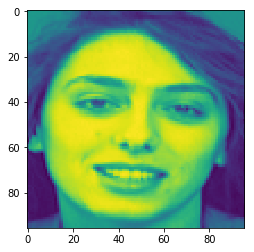

In [220]:
iterator = dataset.make_one_shot_iterator()
next_el = iterator.get_next()
with tf.Session() as sess:
  try:
    while True:
      img, label, add = sess.run(next_el)
      print(label)
      print(add)
      print(img.shape)
      plt.imshow(img.reshape(96, 96))
      break
  except:
    pass

## Test combined dataset record

In [247]:
def plot_imgs(images = [], titles = [], figsize = (10,10)):
  size = len(images)
  fig = plt.figure(figsize=figsize)
  i = 1
  for image in images:
    ax = fig.add_subplot(1,size,i)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(titles[i-1])
    ax.imshow(image)
    i += 1
  return None

dataset = combine_dataset(batch_size=224, image_size=96, same_prob=0.95, diff_prob=.001, train=True)
print(dataset)

<DatasetV1Adapter shapes: (((?, ?, ?, 1), (?,), (?,)), ((?, ?, ?, 1), (?,), (?,))), types: ((tf.float32, tf.int64, tf.string), (tf.float32, tf.int64, tf.string))>


Left: label:  5  img path:  b'./data/s23/9.pgm'  shape:  (224, 96, 96, 1)
Right: label:  5  img_path:  b'./data/s24/10.pgm'  shape:  (224, 96, 96, 1)


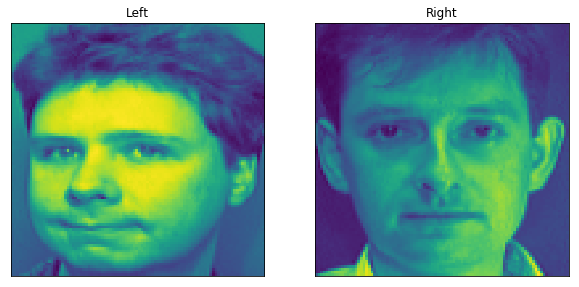

In [248]:
iterator = dataset.make_one_shot_iterator()
next_el = iterator.get_next()
with tf.Session() as sess:
  try:
    while True:
      left, right = sess.run(next_el)
      limg, llbl, ladd = left
      rimg, rlbl, radd = right
      
      x = 1
      
      print("Left: label: ", llbl[x], " img path: ", ladd[x], " shape: ", limg.shape)
      print("Right: label: ", rlbl[x], " img_path: ", radd[x], " shape: ", rimg.shape)
      
      left_img = limg[x].reshape(96, 96)
      right_img = rimg[x].reshape(96, 96)
      
      plot_imgs([left_img, right_img], ["Left", "Right"])
      
      break
  except:
    pass

## Another way to prepare data

In [0]:
!wget http://www.cl.cam.ac.uk/Research/DTG/attarchive/pub/data/att_faces.zip
!unzip att_faces.zip

In [0]:
import re 

def read_image(filename, byteorder='>'):
  
  #first we read the image, as a raw file to the buffer
  with open(filename, 'rb') as f:
    buffer = f.read()
    
  #using regex, we extract the header, width, height and maxval of the image
  header, width, height, maxval = re.search(
      b"(^P5\s(?:\s*#.*[\r\n])*"
      b"(\d+)\s(?:\s*#.*[\r\n])*"
      b"(\d+)\s(?:\s*#.*[\r\n])*"
      b"(\d+)\s(?:\s*#.*[\r\n]\s)*)", buffer).groups()
  #then we convert the image to numpy array using np.frombuffer which interprets buffer as one dimensional array
  return np.frombuffer(buffer,
                       dtype='u1' if int(maxval) < 256 else byteorder+'u2',
                       count=int(width)*int(height),
                       offset=len(header)).reshape((int(height), int(width)))

In [0]:
def get_data(size, total_sample_size):
    #read the image
    image = read_image('data/s' + str(1) + '/' + str(1) + '.pgm', 'rw+')
    #reduce the size
    image = image[::size, ::size]
    #get the new size
    dim1 = image.shape[0]
    dim2 = image.shape[1]

    count = 0
    
    #initialize the numpy array with the shape of [total_sample, no_of_pairs, dim1, dim2]
    x_geuine_pair = np.zeros([total_sample_size, 2, 1, dim1, dim2])  # 2 is for pairs
    y_genuine = np.zeros([total_sample_size, 1])
    
    for i in range(40):
        for j in range(int(total_sample_size/40)):
            ind1 = 0
            ind2 = 0
            
            #read images from same directory (genuine pair)
            while ind1 == ind2:
                ind1 = np.random.randint(10)
                ind2 = np.random.randint(10)
            
            # read the two images
            img1 = read_image('data/s' + str(i+1) + '/' + str(ind1 + 1) + '.pgm', 'rw+')
            img2 = read_image('data/s' + str(i+1) + '/' + str(ind2 + 1) + '.pgm', 'rw+')
            
            #reduce the size
            img1 = img1[::size, ::size]
            img2 = img2[::size, ::size]
            
            #store the images to the initialized numpy array
            x_geuine_pair[count, 0, 0, :, :] = img1
            x_geuine_pair[count, 1, 0, :, :] = img2
            
            #as we are drawing images from the same directory we assign label as 1. (genuine pair)
            y_genuine[count] = 1
            count += 1

    count = 0
    x_imposite_pair = np.zeros([total_sample_size, 2, 1, dim1, dim2])
    y_imposite = np.zeros([total_sample_size, 1])
    
    for i in range(int(total_sample_size/10)):
        for j in range(10):
            
            #read images from different directory (imposite pair)
            while True:
                ind1 = np.random.randint(40)
                ind2 = np.random.randint(40)
                if ind1 != ind2:
                    break
                    
            img1 = read_image('data/s' + str(ind1+1) + '/' + str(j + 1) + '.pgm', 'rw+')
            img2 = read_image('data/s' + str(ind2+1) + '/' + str(j + 1) + '.pgm', 'rw+')

            img1 = img1[::size, ::size]
            img2 = img2[::size, ::size]

            x_imposite_pair[count, 0, 0, :, :] = img1
            x_imposite_pair[count, 1, 0, :, :] = img2
            #as we are drawing images from the different directory we assign label as 0. (imposite pair)
            y_imposite[count] = 0
            count += 1
            
    #now, concatenate, genuine pairs and imposite pair to get the whole data
    X = np.concatenate([x_geuine_pair, x_imposite_pair], axis=0)/255
    Y = np.concatenate([y_genuine, y_imposite], axis=0)

    return X, Y

In [0]:
X, Y = get_data(2, 10000)
print(X.shape)

(20000, 2, 1, 56, 46)


[0.]


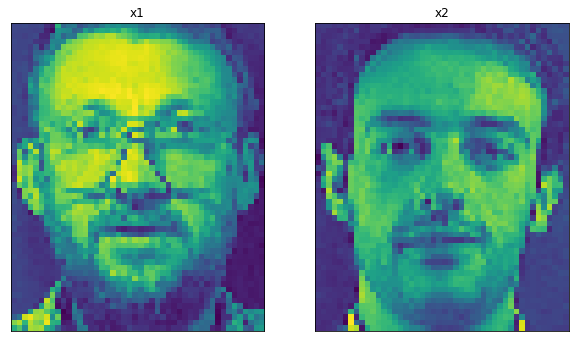

In [0]:
n = 18000

img = X[n]
lbl = Y[n]

print(lbl)

plot_imgs(images=[img[0][0], img[1][0]] , titles=["x1", "x2"])

In [0]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=.20)

## Build the model 

In [0]:
def net_img_input(image_shape, name):
  return tf.placeholder(tf.float32, shape=[None, image_shape[0], image_shape[1], image_shape[2]], name=name)

def net_lbl_input(n_classes):
  return tf.placeholder(tf.float32, shape=[None, n_classes], name='y')

def conv2d_maxpool(x_tensor, conv_num_out, conv_ksize, conv_strides, pool_ksize, pool_strides):
  weights = tf.Variable(tf.truncated_normal([conv_ksize[0], conv_ksize[1], int(x_tensor.shape[3]), conv_num_out]))
  bias = tf.Variable(tf.zeros([conv_num_out]))
  
  x_tensor = tf.nn.conv2d(x_tensor, weights, strides=[1, conv_strides[0], conv_strides[1], 1], padding='SAME')
  x_tensor = tf.nn.bias_add(x_tensor, bias)
  x_tensor = tf.nn.relu(x_tensor)
  x_tensor = tf.nn.max_pool(x_tensor, ksize=[1, pool_ksize[0], pool_ksize[1], 1], strides=[1, pool_strides[0], pool_strides[1], 1], padding='SAME')
  return x_tensor

def flatten(x_tensor):
  image_dimensions = x_tensor.get_shape().as_list()
  image_flat_size = image_dimensions[1] * image_dimensions[2] * image_dimensions[3]
  
  return tf.reshape(x_tensor, [-1, image_flat_size])

def dense(x_tensor, num_outputs):
  weights = tf.Variable(tf.truncated_normal([int(x_tensor.shape[-1]), num_outputs], mean=0.0, stddev=0.1))
  bias = tf.Variable(tf.zeros([num_outputs]))
  
  x_tensor = tf.add(tf.matmul(x_tensor, weights), bias)
  x_tensor = tf.nn.sigmoid(x_tensor)
  
  return x_tensor

def output(x_tensor, num_outputs):
  weights = tf.Variable(tf.truncated_normal([int(x_tensor.shape[-1]), num_outputs], mean=0.0, stdev=0.1))
  bias = tf.Variable(tf.zeros([num_outputs]))
  
  x_tensor = tf.add(tf.matmul(x_tensor, weights), bias)
  
  return x_tensor